In [22]:
# imports
import sys
# setting path
sys.path.append('..')
from src import framework__data_set as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import TCNModel
from darts import concatenate
import darts.utils.timeseries_generation as tg
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values, extract_subseries
from darts.metrics import mae, rmse
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt

Loading both CPU and memory data of the collector application into separate datasets:

In [23]:
cpu_dataset = ds.get_data_set(
    metric="container_cpu",
    application_name="collector",
    path_to_data="../data/OperatreFirst_PrometheusData_AppLearner/"
)

mem_dataset = ds.get_data_set(
    metric="container_mem",
    application_name="collector",
    path_to_data="../data/OperatreFirst_PrometheusData_AppLearner/"
)



Defining a transformer that scales the data, limiting the values between -1 and 1:

In [24]:
scaler = MinMaxScaler(feature_range=(-1, 1))
transformer = Scaler(scaler)

In [25]:
# sort_by_time builds the merge dataset so we can use get_marged later.
cpu_dataset.sort_by_time()
mem_dataset.sort_by_time()

cpu_merge_series = TimeSeries.from_dataframe(cpu_dataset.get_marged(), time_col='time', value_cols='sample',
                                     fill_missing_dates=True)
mem_merge_series = TimeSeries.from_dataframe(mem_dataset.get_marged(), time_col='time', value_cols='sample',
                                     fill_missing_dates=True)

Activating the transformer on our current data:

In [26]:
cpu_merge_series = transformer.fit_transform(cpu_merge_series)
mem_merge_series = transformer.fit_transform(mem_merge_series)



Ploting all the data as a time_series for both CPU and memory:

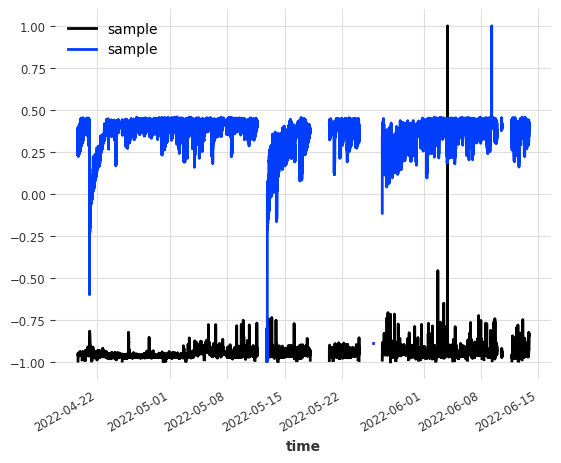

In [27]:
cpu_merge_series.plot()
mem_merge_series.plot()

We are performing an inner join of both datasets to obtain only the time steps that are common to both. This ensures that for each time step, we have both CPU and memory values available:

In [28]:
merged_df = pd.merge(cpu_dataset.get_marged(), mem_dataset.get_marged(), on='time', how='inner')
merged_df.head()

,index_x,time,sample_x,application_name_x,node_x,pod_x,namespace_x,index_y,sample_y,application_name_y,node_y,pod_y,namespace_y
0,0,2022-04-19 17:16:00,0.031622,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging,0,717082624.0,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging
1,1,2022-04-19 17:17:00,0.081125,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging,1,724856832.0,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging
2,2,2022-04-19 17:18:00,0.119493,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging,2,728907776.0,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging
3,3,2022-04-19 17:19:00,0.176340,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging,3,748130304.0,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging
4,4,2022-04-19 17:20:00,0.228240,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging,4,688713728.0,collector,oct-10-06-control,klusterlet-addon-search-cf585dd6-slph4,openshift-logging


As before, we're activating the transformer on our current data and ploting it:

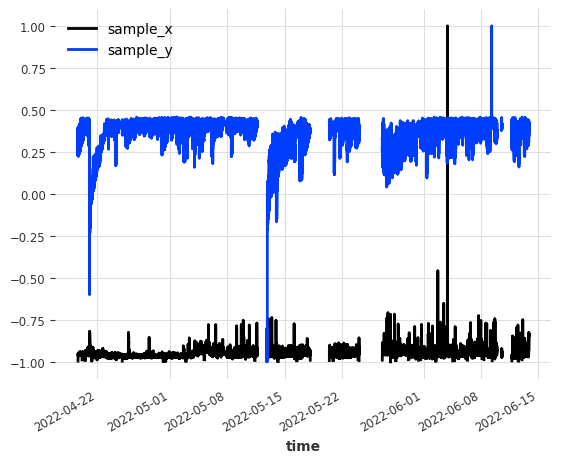

In [29]:
cpu_merge_series = TimeSeries.from_dataframe(merged_df, time_col='time', value_cols='sample_x',
                                     fill_missing_dates=True)
mem_merge_series = TimeSeries.from_dataframe(merged_df, time_col='time', value_cols='sample_y',
                                     fill_missing_dates=True)

cpu_merge_series = transformer.fit_transform(cpu_merge_series)
mem_merge_series = transformer.fit_transform(mem_merge_series)

cpu_merge_series.plot()
mem_merge_series.plot()

After obtaining the time steps that have both CPU and memory values, we are extracting them into a continuous series using the extract_subseries function from the Darts library:

In [30]:
cpu_series_lst = extract_subseries(cpu_merge_series, min_gap_size=1, mode='all')
mem_series_lst = extract_subseries(mem_merge_series, min_gap_size=1, mode='all')


We are currently concatenating the corresponding time series into a single 3-dimensional time series, as suggested by the Darts library documentation, using the concatenate function. We are excluding series that are shorter than 122 time steps, as our minimum length requirement is 122 due to the sum of the input and output chunk lengths, which are parameters for our model

In [31]:
multivariate_series_lst = []
for cpu_series, mem_series in zip(cpu_series_lst, mem_series_lst):
    if min(len(cpu_series), len(mem_series)) <= 122:
        continue
    multivariate_series = concatenate([cpu_series, mem_series], axis=1)
    multivariate_series_lst.append(multivariate_series)
    

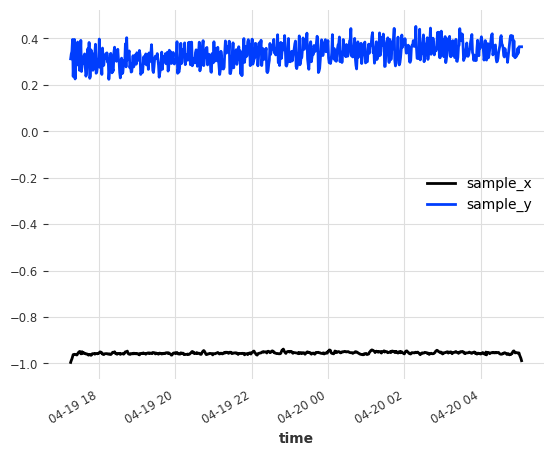

In [32]:
multivariate_series_lst[0].plot()

We are splitting the data into train and test sets:

In [33]:
# get interval
number = int("12") % int(len(multivariate_series_lst) * 0.2)
print(int(len(multivariate_series_lst) * 0.8) + number, len(multivariate_series_lst))
test_series_lst, train_series_lst = multivariate_series_lst[int(len(multivariate_series_lst) * 0.8) + number:], multivariate_series_lst[:int(len(multivariate_series_lst) * 0.8) + number]


26 33


Loading the pretrained model:

In [4]:
model_loaded = TCNModel.load("../TrainedModels/TCN/Multivariate_TCN_model.pt")
model_loaded.to_cpu()


Historical forecasting:

In [35]:
backtest_en = model_loaded.historical_forecasts(
        series=test_series_lst,
        past_covariates=None,
        forecast_horizon=60,
        stride = 3,
        retrain=False,
        verbose=False,
)

In [36]:
# Create a moving average filter with a window size of 3
ma_filter = MovingAverageFilter(window=4)

We are plotting the backtest together with the original data for each time series after performing a reverse transform to restore the original values. Additionally, we are calculating and printing some comparing metrics:

Number of samples: 2460
MAE: 0.039403061376435414
RMSE: 0.053391680852065776


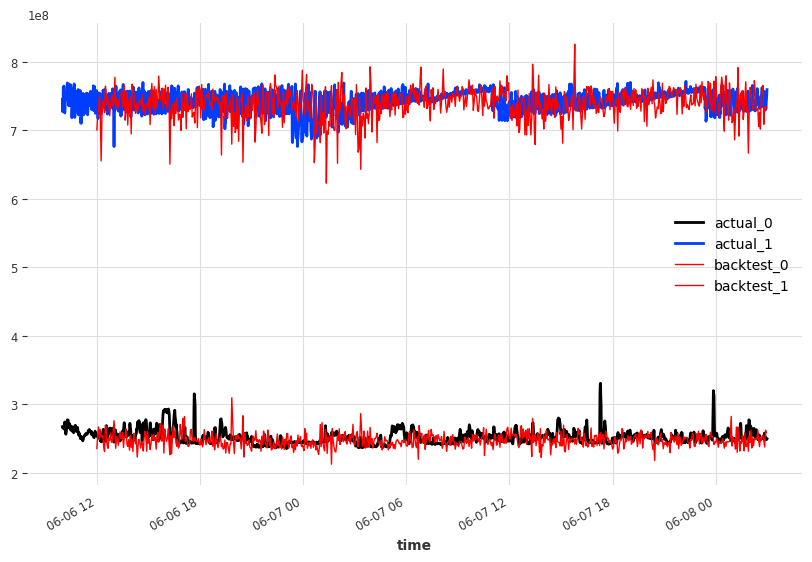

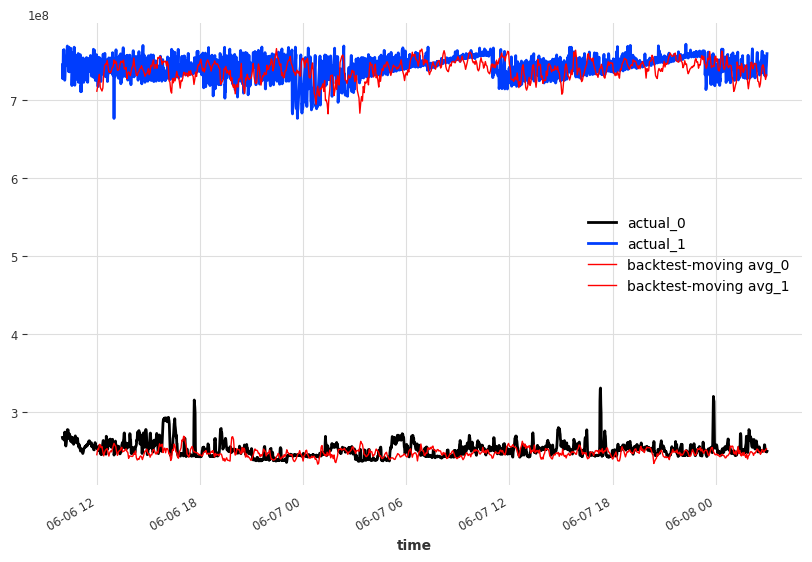

Number of samples: 1444
MAE: 0.032981424489557334
RMSE: 0.044675731797822346


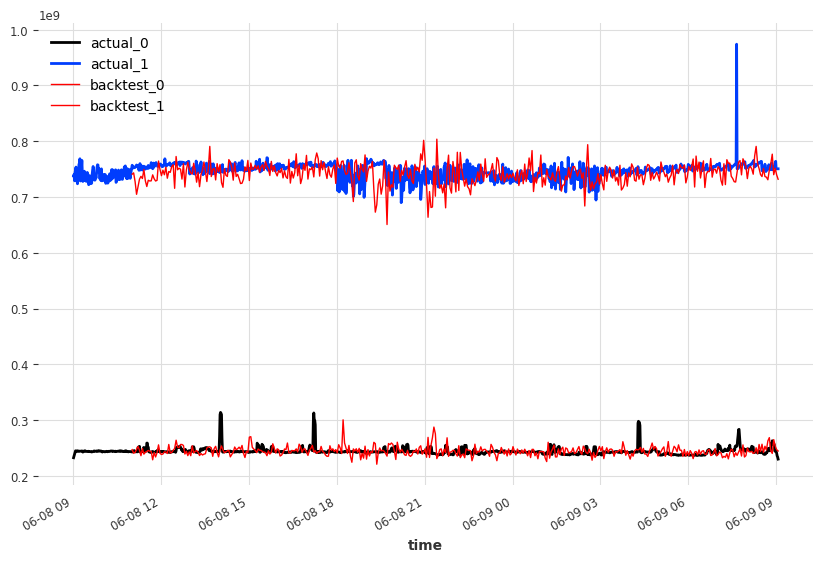

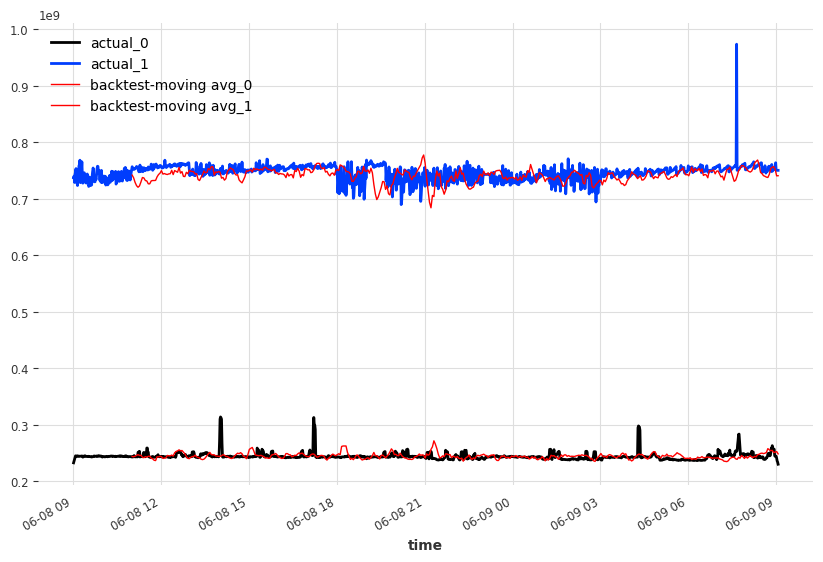

Number of samples: 660
MAE: 0.03573434029286165
RMSE: 0.04626097344245382


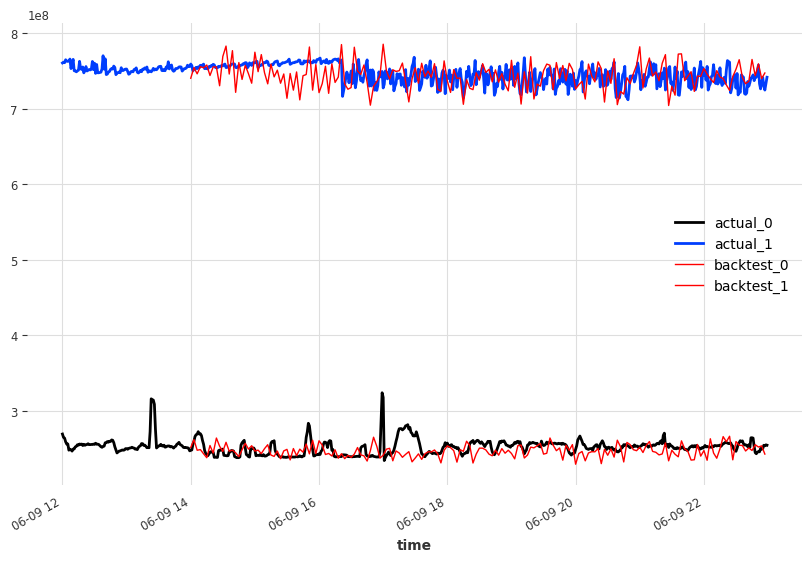

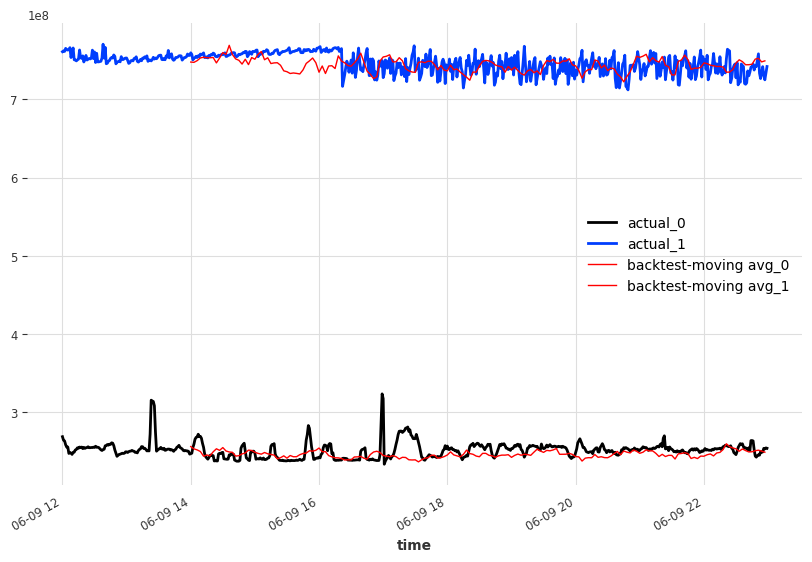

Number of samples: 1084
MAE: 0.04023621417127662
RMSE: 0.05415217043906928


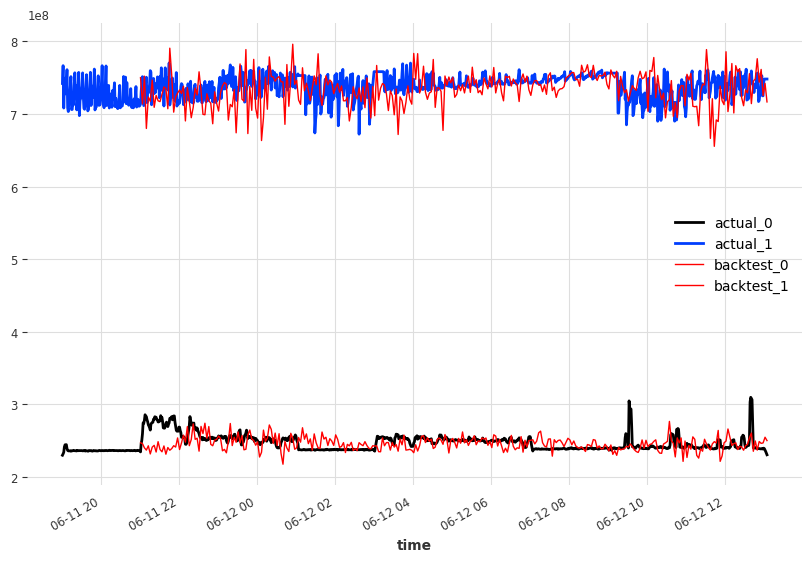

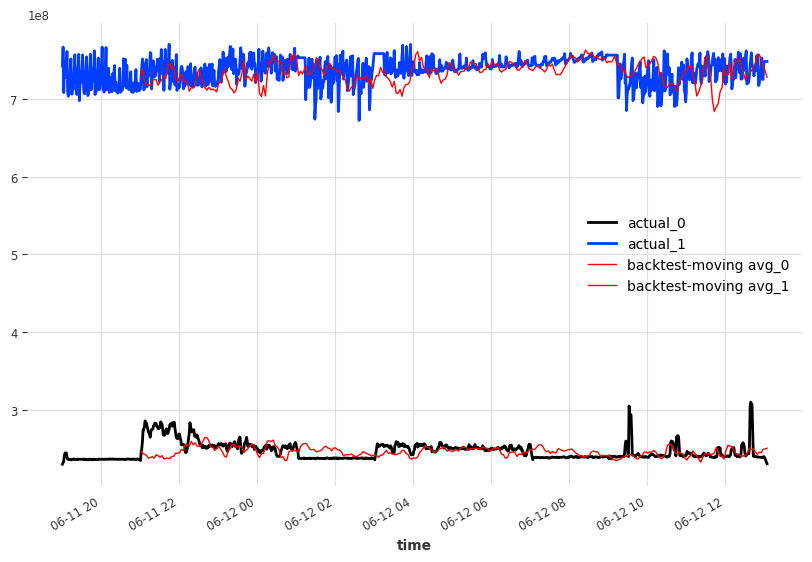

Number of samples: 1200
MAE: 0.03748047164931976
RMSE: 0.05180288096563279


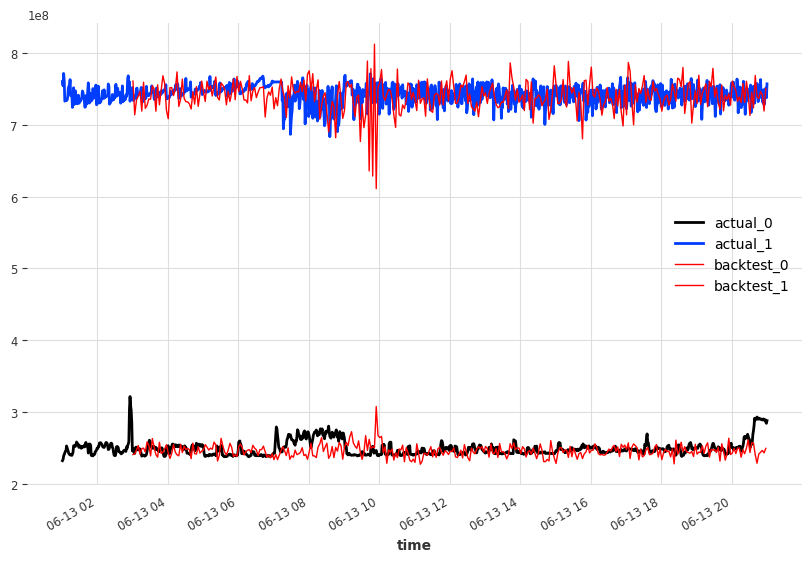

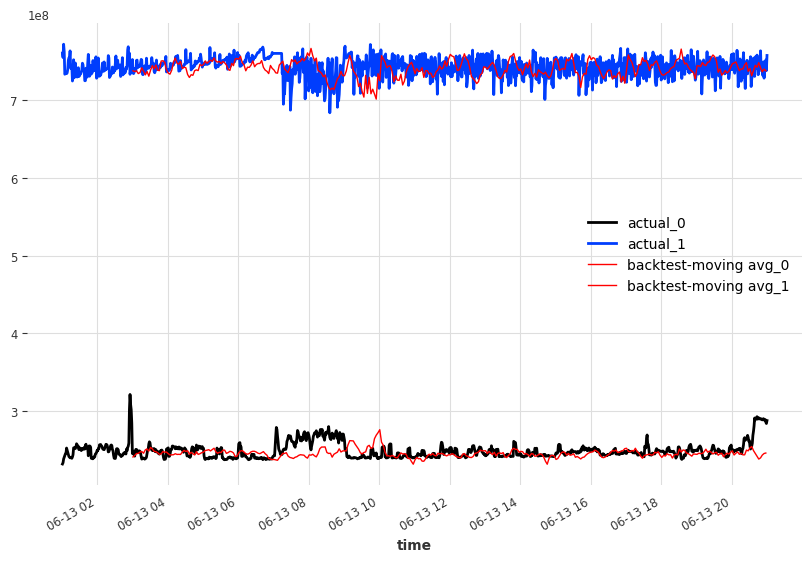

In [37]:
for orig, backtest in zip(test_series_lst, backtest_en):
    if len(orig) < 500:
        continue
    maes = mae(orig, backtest, n_jobs=1, verbose=False)
    rmses = rmse(orig, backtest, n_jobs=1, verbose=False)
    print("Number of samples:", len(orig))
    print("MAE:", maes)
    print("RMSE:", rmses)
    plt.figure(figsize=(10, 6))
    orig_untransformed = transformer.inverse_transform(orig)
    backtest_untransformed = transformer.inverse_transform(backtest)
    # Apply the filter to the time series
    filtered_backtest = ma_filter.filter(backtest_untransformed)
    orig_untransformed.plot(label="actual")
    backtest_untransformed.plot(label="backtest", linewidth=1, color='red')
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 6))
    orig_untransformed.plot(label="actual")
    filtered_backtest.plot(label="backtest-moving avg", linewidth=1, color='red')
    plt.legend()
    plt.show()